# Deep Reinforcement Learning <br>

In this notebook a basic implementation of the "Deep Q Learning" algorithm for Deep Reinforcement Learning is provided. Deep Q Learning is a tecnique that uses a Neural Network to make the agent estimate the rewards of the next possible actions.  

### Table of Contents

* [1 Bellman equation](#chapter1)
    * [1.1 Definitions](#section_1_1)
    * [1.2 Fixed point](#section_1_2)
    * [1.3 Algorithm](#section_1_3)
* [2 Code](#chapter2)
    * [2.1 Replay memory](#section_2_1)
    * [2.2 Neural Network](#section_2_2)
    * [2.3 Agent](#section_2_3)
    * [2.4 Main](#section_2_4)

## 1. Bellman equation <a class="anchor" id="chapter1"></a>

### 1.1 Definitions <a class="anchor" id="section_1_1"></a>

Let's first define [1] an environemnt giving a set $\mathcal{S}$ of possible states $s$ in which the agent can find himself. Let's also define a set $\mathcal{A}$ of actions $a$ in between the agent can choose to move around in the space. We call $R_k$ the reward that the agent receivs at the discrete step $k$ after choosing a certain action and going into a certain state. <br>

Then the objective of the agent at a certain discrete time $t$ is to maximize the future global reward: $G_t = \sum\limits_{k = t+1}^T R_k$, where $T$ is the final time. So $R_{t+1}$ is the immediate reward, while the followings are the future ones. Obviously, the agent will be more interested in the immediate reward rather than the future ones, so we can introduce what is called a discount factor $\gamma \in [0,1]$, which reduced the importance of future rewards. The final formula for the function that at every step the agent wants to maximize is:
$$
    G_t = \sum\limits_{k = t+1}^T {\gamma}^{k-t-1} R_k
$$

The agent will have a strategy to decide, given a state $s$, which action to take. This strategy is called "policy", and it's a function $\pi : \mathcal{S} \times \mathcal{A} \to [0,1]$ that, given a state $s$ in which the agent is, gives the probability for the agent to take the action $a$. <br>
If we call the current state $s$, then we call $s'$ the following one. We can define then also the probability $p(s', r|s, a)$, which in the probability of the agent to go in the next state $s'$ and get the reward $r$, given that he is in the state $s$ and took the action $a$.

We now define the $Q_{\pi} : \mathcal{S} \times \mathcal{A} \to \mathbb{R}$ function, which we will use in the algorithm, which is the expected reward given the state and the action. So 

$$
    Q_{\pi}(s, a) = \mathbb{E}_{\pi}[G_t | S_t = s, A_t = a]
$$

The last thing we define is the value function $V_{\pi} : \mathcal{S} \to \mathbb{R}$, which is defined as 
$$
    V_{\pi}(s) = \mathbb{E}_{\pi}[G_t | S_t = s]
$$

which is the expected value from state $s$ if the agent follows the policy $\pi$.<br>



### 1.2 Fixed point <a class="anchor" id="section_1_2"></a>


Then it can be proved that [2]: 

$$
    V_{\pi}(s) = \sum\limits_{a \in \mathcal{A}} \pi(a|s) \sum\limits_{s' \in \mathcal{S}} \sum\limits_{r \in \mathcal{R}} p(s', r|s, a)\left[r+\gamma V_{\pi}(s')\right]
$$
 
Which shows that the the $V_{\pi}$ value function contains itself. 

Analogously it's true that:
$$
    Q_{\pi}(s, a) = \sum\limits_{s' \in \mathcal{S}} \sum\limits_{r \in \mathcal{R}} p(s', r|s, a)\left[r+\gamma Q_{\pi}(s', a)\right]
$$
 
It can be proved that these equations are contractions with increasing values, which means that, because of the Banach theorem, there exists a fixed point $Q^*_{\pi}$ such that:

$$
    Q^*_{\pi}(s, a) = \sum\limits_{s' \in \mathcal{S}} \sum\limits_{r \in \mathcal{R}} p(s', r|s, a)\left[r+\gamma Q^*_{\pi}(s, a)\right] 
$$

and since every contraction increases the value, it's intuitive that 
$$
    Q^*_{\pi} = \max\limits_{a \in \mathcal{A}}Q(s,a)
$$

So the equation is:

$$
    Q^*_{\pi}(s, a) = \mathbb{E}_{\pi}\left[r+\gamma \max\limits_{a \in \mathcal{A}}Q_{\pi}(s, a)\right]
$$

### 1.3 Algorithm <a class="anchor" id="section_1_3"></a>

We will build a neural network which tries to approximate the $Q$ function, and we thus want it to have, as output, the fixed point $Q^*_{\pi}(s, a) = \mathbb{E}_{\pi}\left[r+\gamma \max\limits_{a \in \mathcal{A}}Q_{\pi}(s, a)\right]$

In order to do so, we will use the following loss function [1]:

$$
    L = \left(Y(s', a) -  Q(s,a)\right)^2
$$

where $Y(s', a) = r+\gamma \max\limits_{a \in \mathcal{A}}Q_{\pi}(s', a)$.

We endow our agent with a memory, where all the information about the previous played states, actions, rewards, etc, are stored. Iterating the above formula on a batch of values $(s,a)$ from the memory will lead to an average value $L = \mathbb{E}\left[\left( Y(s', a) - Q(s,a) \right)^2\right] $. Minimizing this loss function will lead to the desired output. <br>

In fact, given a generic variance $\mathbb{E}\left[\left( X - c \right)^2\right] $, it's easy to show that the minimum value is reached when $c = \mathbb{E}[X]$. Equally, in this case, the minimum of the loss funcion $ L = \mathbb{E}\left[\left( Y(s', a) - Q(s,a) \right)^2\right]$ will be reached when 

$$
    Q(s,a) = \mathbb{E}\left[r+\gamma \max\limits_{a \in \mathcal{A}}Q_{\pi}(s', a)\right]
$$

which is exactly the desired output, the solution of the bellman equation.

References: <br> 
[1] Sutton book: https://mitpress.mit.edu/books/reinforcement-learning-second-edition <br>
    [2] Bellman equation: https://stats.stackexchange.com/questions/243384/deriving-bellmans-equation-in-reinforcement-learning <br>
    [3] Theoretical review: https://arxiv.org/pdf/1901.00137.pdf <br>
    


## 2. Code <a class="anchor" id="chapter2"></a>

References: <br>
[1] Coding tutorial: https://www.youtube.com/watch?v=wc-FxNENg9U <br>

In [1]:
# usual
import numpy as np
import matplotlib.pyplot as plt

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim

# gym
import gym

### 2.1 Replay Memory <a class="anchor" id="section_2_1"></a>

In [2]:
class ReplayMemory():
    """
    Memory of the agent where all the moves and the episodes will be saved
    """
    def __init__(self, max_mem_size, input_dim):
        # maximum size of the memory
        self.mem_size = max_mem_size
        
        # number of items in the memory
        self.mem_counter = 0
        
        # information that the memory will store
        self.state_memory = np.zeros((self.mem_size, *input_dim), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dim), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)
    
    def push(self, state, action, reward, next_state, done):
        """
        push new information into the memory
        """
        # index to eventually overwrite past memory
        index = self.mem_counter % self.mem_size
        
        # push the information
        self.state_memory[index] = state
        self.new_state_memory[index] = next_state
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done
        
        # increase the counter
        self.mem_counter += 1
        
    def sample(self, batch_size):
        """
        get some information from the memory
        """
        # get number of info in memory
        max_mem = min(self.mem_counter, self.mem_size)
        
        # select 'batch_size' randon numbers in the interval [0, max_mem]
        sample_indices = np.random.choice(a = max_mem, size = batch_size, replace=False)
        
        # get an array of evenly spaced ints [0, 1, 2,..., batch_size]
        batch_indices = np.arange(batch_size, dtype=np.int32)
        
        # sample from the memory 
        state_batch = torch.tensor(self.state_memory[sample_indices])
        new_state_batch = torch.tensor(self.new_state_memory[sample_indices])
        reward_batch = torch.tensor(self.reward_memory[sample_indices])
        terminal_batch = torch.tensor(self.terminal_memory[sample_indices])
        action_batch = self.action_memory[sample_indices]
        
        return batch_indices, state_batch, new_state_batch, reward_batch, terminal_batch, action_batch 

### 2.2 Neural Network <a class="anchor" id="section_2_2"></a>

In [3]:
class NeuralNetwork(nn.Module):
    """
    Neural network used to apprixmate the Q funcion
    """
    def __init__(self, lr, input_dim, layer1_dim, layer2_dim, n_actions):
        super(NeuralNetwork, self).__init__()
        
        # dimensions
        self.input_dim = input_dim
        self.layer1_dim = layer1_dim
        self.layer2_dim = layer2_dim
        self.output_dim = n_actions
        
        # layers
        self.layer1 = nn.Linear(*self.input_dim, self.layer1_dim)
        self.layer2 = nn.Linear(self.layer1_dim, self.layer2_dim)
        self.layer3 = nn.Linear(self.layer2_dim, self.output_dim)
        
        # optimizer and loss
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
    
    def forward(self, state):
        """
        Forward pass
        """
        # architecture
        x = functional.relu(self.layer1(state))
        x = functional.relu(self.layer2(x))
        actions = self.layer3(x)
        
        return actions

### 2.3 Agent <a class="anchor" id="section_2_3"></a>

In [4]:
class Agent():
    """
    Agent that will implement the deep Q-Learning algorithm
    """
    def __init__(self, gamma, epsilon, lr, input_dim, batch_size, n_actions, max_mem_size = 100000, eps_end=0.01, eps_dec=5e-4):
        # agent params
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_end = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.batch_size = batch_size
        
        # action space
        self.action_space = [i for i in range(n_actions)]
        
        # neural net
        self.neural_net = NeuralNetwork(self.lr, n_actions=n_actions, input_dim = input_dim, layer1_dim = 128, layer2_dim = 128)
        
        # memory
        self.memory = ReplayMemory(max_mem_size, input_dim)
            
            
    def store_transition(self, state, action, reward, next_state, done):
        """
        Store one transition into the memory
        """
        self.memory.push(state, action, reward, next_state, done)
        
        
    def choose_action(self, observation):
        """
        Choose next action
        """
        # if epsilon is low enough 
        if np.random.random() > self.epsilon: 
            # then choose with the neural net
            state = torch.tensor([observation])
            actions = self.neural_net.forward(state)
            action = torch.argmax(actions).item()
        else:
            # otherwise do a random action
            action = np.random.choice(self.action_space)
        
        return action
    
    
    def learn(self):
        """
        Learn from past experience
        """
        # if there is not enough information in the memory
        if self.memory.mem_counter < self.batch_size:
            # it's not yet time to learn
            return
          
        # otherwise, for a certain amount of iterations
        for i in range(2):  
            # reset the grad
            self.neural_net.optimizer.zero_grad()
        
            # sample some information from the memory
            batch_indices, state_batch, new_state_batch, reward_batch, terminal_batch, action_batch = self.memory.sample(self.batch_size)
        
            # Calculate Q(s,a), the Q value of the initial state
                # The NN takes as input a state and returns the Q values of that state for the possible actions (here 2)
                # If we pass an array of states, it returns an array of arryas:
                    # this means: [[value of all possible actions of state 0], [value of all possible actions of state 1],...]
                # Then we get the elements [batch_indices, action_batch]
                    # this means: for every action in batch_index=[0, 1, ..., batch_dim], 
                    # select the action that the agent actually took, which is in action_batch = [0, 0, 1, 0, 1, ... ]
            Q_itial_state = self.neural_net.forward(state_batch)[batch_indices, action_batch]
        
            # calculate Q(s',a), the Q value of the final state
            Q_final_state = self.neural_net.forward(new_state_batch)
            # if the final state was a terminal one, then there is no expected value for future moves
            Q_final_state[terminal_batch] = 0.0
            # calculate Y = r + γmax(Q(s',a))
            # note: torch.max returns (value, index). We only want the value.
            Y = reward_batch + self.gamma * torch.max(Q_final_state, dim=1)[0]

            # training step
            loss = self.neural_net.loss(Y, Q_itial_state)
            loss.backward()
            self.neural_net.optimizer.step()
        
        # decrease epsilon
        if self.epsilon > self.eps_end:
            self.epsilon = self.epsilon - self.eps_dec
        else: 
            self.epsilon = self.eps_end

### 2.4 Main <a class="anchor" id="section_2_4"></a>

In [5]:
# crate environment 
env = gym.make('CartPole-v1')

# observation and action space
n_actions = env.action_space.n
input_dim = env.observation_space.shape[0]

# create agent
agent = Agent(gamma=0.99, epsilon=1, batch_size=64, n_actions=n_actions, eps_end=0.01, input_dim=[input_dim], lr=0.0001)

# params
scores, eps_history = [], []
n_games = 500

# for every episode
for i in range(n_games):
    # reset everything
    score = 0
    cost = 0
    done = False
    observation = env.reset()
    
    # while the agent is still playing
    while not done:
        
        # choose an action
        action = agent.choose_action(observation)
        
        # make a step 
        new_observation, reward, done, info = env.step(action)
        
        # sum the reward
        score += reward
        
        # store the transition 
        agent.store_transition(observation, action, reward, new_observation, done)
        
        # learn from experience
        agent.learn()
        
        # start from new observation
        observation = new_observation

    # append the score 
    scores.append(score)

    # append epsilon
    eps_history.append(agent.epsilon)
    
    # avrage the score 
    avg_score = np.mean(scores[-50:])
    
    # plot each n steps
    if i%50 == 0:
        print('episode', i, 'score %.2f' % score, 'last 10 average score %2.f' % avg_score, 'epsilon %.2f' %agent.epsilon)

episode 0 score 12.00 last 10 average score 12 epsilon 1.00
episode 50 score 21.00 last 10 average score 22 epsilon 0.48
episode 100 score 32.00 last 10 average score 52 epsilon 0.01
episode 150 score 156.00 last 10 average score 206 epsilon 0.01
episode 200 score 139.00 last 10 average score 279 epsilon 0.01
episode 250 score 336.00 last 10 average score 273 epsilon 0.01
episode 300 score 228.00 last 10 average score 300 epsilon 0.01
episode 350 score 290.00 last 10 average score 305 epsilon 0.01
episode 400 score 187.00 last 10 average score 298 epsilon 0.01
episode 450 score 387.00 last 10 average score 322 epsilon 0.01


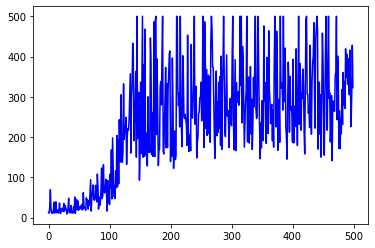

In [6]:
plt.plot(scores, color='blue');

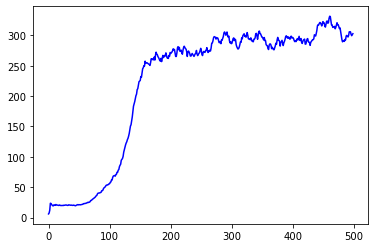

In [7]:
# plot the averaged results
avgs = []
span = 40
for i in range(1,len(scores)):
    
    start = i-span
    if start < 0:
        start = 0

    current = scores[start:i]
    avg = sum(current)/(len(current)+1)
    avgs.append(avg)
plt.plot(avgs, color='blue')

## 3 Conclusions <a class="anchor" id="chapter3"></a>

As it can be seen, the agent does learn how to play. Thought , after ~200 steps, it starts having more troubles learning. The reason is that one thing that is missing in this algorithm is the target net. To converge, the deep q learning algorithm need another neural network. One will estimate the function $Q(s,a;\theta)$, while the other one the function $Q(s',a;\theta')$. The implementation of the target net is a proposal for future developments of the project. It's interesting to see though, that at this stage, this simple and basic implementation already fulfills the task. 